# Adaboost

In [ ]:
#encoding=utf8
import numpy as np
#adaboost算法
class AdaBoost:
    '''
    input:n_estimators(int):迭代轮数
          learning_rate(float):弱分类器权重缩减系数
    '''
    def __init__(self, n_estimators=50, learning_rate=1.0):
        # 初始化迭代轮数和学习率
        self.clf_num = n_estimators
        self.learning_rate = learning_rate
    
    def init_args(self, datasets, labels):
        # 初始化训练数据X和标签Y，以及样本数M和特征数N
        self.X = datasets
        self.Y = labels
        self.M, self.N = datasets.shape
        
        # 初始化分类器集合
        self.clf_sets = []
        
        # 初始化样本权重均匀分布，初始时每个样本权重相等
        self.weights = [1.0/self.M]*self.M
        
        # G(x)系数 alpha：存储每个弱分类器的权重
        self.alpha = []
    def _G(self, features, labels, weights):
        """寻找一个最佳的弱分类器——通过遍历所有可能的阈值v，
        找到使加权分类误差最小的阈值v和对应的分类方向direct为'positive'或'nagetive'
        以及该阈值下对所有样本的分类结果compare_array
        以及该阈值下的分类误差error
        该弱分类器的分类结果为：G(x)=1 if x>v else -1 (正向)
                            或 G(x)=-1 if x>v else 1 (反向)
        """
        '''
        input:features(ndarray):数据特征
              labels(ndarray):数据标签
              weights(ndarray):样本权重系数
        '''
        #********* Begin *********#
        m = len(features) # 样本数self.M
        # 获取特征的最小值和最大值=>遍历区间
        features_min = min(features)
        features_max = max(features)
        # 通过特征的最小值和最大值，计算在特征区间内可以尝试的步数
        n_step = (features_max - features_min + self.learning_rate) // self.learning_rate
        # 初始化循环参数，用于存储最佳阈值v，分类方向direct，分类结果compare_array
        error = 100000.0 # 无穷大
        best_v = 0.0
        direct, compare_array = None, None
        # 遍历所有可能的阈值v
        for i in range(1, int(n_step)):
            # 遍历从features_min到features_max区间内的每一个阈值v，以步长self.learning_rate进行迭代
            v = features_min + self.learning_rate * i
            
            if v not in features:
                # 使用两个不同的分类方向来计算误分类
                # 正向
                compare_array_positive = np.array([1 if features[k] > v else -1 for k in range(m)]) # 正向比较
                weight_error_positive = sum([weights[k] for k in range(m) if compare_array_positive[k] != labels[k]]) # 计算加权分类误差，即权重和分类错误样本数之和
                # 反向
                compare_array_nagetive = np.array([-1 if features[k] > v else 1 for k in range(m)])
                weight_error_nagetive = sum([weights[k] for k in range(m) if compare_array_nagetive[k] != labels[k]])
                # 选择加权分类误差较小的分类方向，并记录该分类方向下的分类结果compare_array和分类误差weight_error
                if weight_error_positive < weight_error_nagetive:
                    weight_error = weight_error_positive
                    _compare_array = compare_array_positive
                    direct = 'positive'
                else:
                    weight_error = weight_error_nagetive
                    _compare_array = compare_array_nagetive
                    direct = 'nagetive'
                # 如果该分类误差weight_error小于历史最小误差error，则更新最佳阈值v，分类方向direct，分类结果compare_array和分类误差error
                if weight_error < error:
                    error = weight_error
                    compare_array = _compare_array
                    best_v = v
        return best_v, direct, error, compare_array
    # 计算alpha
    def _alpha(self, error):
        return 0.5 * np.log((1-error)/error)
    
    # 规范化因子
    def _Z(self, weights, a, clf):
        return sum([weights[i]*np.exp(-1*a*self.Y[i]*clf[i]) for i in range(self.M)])
        
    # 权值更新
    def _w(self, a, clf, Z):
        for i in range(self.M):
            self.weights[i] = self.weights[i]*np.exp(-1*a*self.Y[i]*clf[i])/ Z
    
    # G(x)的线性组合   
    def G(self, x, v, direct):
        if direct == 'positive':
            return 1 if x > v else -1 
        else:
            return -1 if x > v else 1 
    
    def fit(self, X, y):
        self.init_args(X, y)
        
        for epoch in range(self.clf_num):
            best_clf_error, best_v, clf_result = 100000, None, None
            # 根据特征维度, 选择误差最小的
            for j in range(self.N):
                features = self.X[:, j]
                # 针对每个特征，调用_G方法来选择最佳的阈值v和分类方向（正/负）
                # 分类阈值，分类误差，分类结果
                v, direct, error, compare_array = self._G(features, self.Y, self.weights)
                
                if error < best_clf_error:
                    best_v = v
                    final_direct = direct
                    best_clf_error = error
                    clf_result = compare_array
                    axis = j
                    
                if best_clf_error == 0:
                    break
                
            # 计算G(x)系数a
            a = self._alpha(best_clf_error)
            self.alpha.append(a)
            # 记录分类器
            self.clf_sets.append((axis, best_v, final_direct))
            # 规范化因子
            Z = self._Z(self.weights, a, clf_result)
            # 权值更新
            self._w(a, clf_result, Z)
        #********* End *********#
    def predict(self, feature):
        result = 0.0
        for i in range(len(self.clf_sets)):
            axis, clf_v, direct = self.clf_sets[i]
            f_input = feature[axis]
            result += self.alpha[i] * self.G(f_input, clf_v, direct)
        # 为正数，分类为1
        return 1 if result > 0 else -1
    def score(self, X_test, y_test):
        y_pred = []
        for i in range(len(X_test)):
            y_pred.append(self.predict(X_test[i]))
        y_pred = np.array(y_pred)
        return sum(y_pred == y_test)/len(y_test)

In [6]:
#encoding=utf8
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection  import train_test_split
import pandas as pd

#获取并处理鸢尾花数据
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    data = np.array(df.iloc[:100, [0, 1, -1]])
    for i in range(len(data)):
        if data[i,-1] == 0:
            data[i,-1] = -1
    return data[:,:2], data[:,-1]

x,y = create_data()
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=605)

ada = AdaBoost(n_estimators=50,learning_rate=0.2)
ada.fit(x_train,y_train)

acc = ada.score(x_test, y_test)

if acc>0.95:
    print('正确率大于0.95')
else:
    print('正确率为%.3f,请修改'%acc)


正确率大于0.95


# 核化池
##  第一关 实现核函数

In [ ]:
# 第一关 实现核函数
import numpy as np

class Kernel(object):
    def __init__(self, gamma=1.0, coef0=1, degree=3):
        '''
        初始化核函数参数
        input:
            gamma (float): 核函数的缩放参数
            coef0 (float): 多项式核中的常数项
            degree (int): 多项式核的次数
        '''
        self.gamma, self.coef0, self.degree = gamma, coef0, degree

    def linear(self, X1, X2):
        '''
        线性核函数
        input:
            X1 (ndarray): 形状 (n_samples1, n_features) 的样本矩阵
            X2 (ndarray): 形状 (n_samples2, n_features) 的样本矩阵
        output:
            ndarray: 线性核矩阵
        '''
        #********* Begin *********#
        return np.dot(X1, X2.T)
        #********* End *********#


    def poly(self, X1, X2):
        '''
        多项式核函数
        input:
            X1 (ndarray): 样本矩阵
            X2 (ndarray): 样本矩阵
        output:
            ndarray: 多项式核矩阵
        '''
        #********* Begin *********#
        return (self.gamma * np.dot(X1, X2.T) + self.coef0) ** self.degree
        #********* End *********#


    def gaussian(self, X1, X2):
        '''
        高斯核 
        input:
            X1 (ndarray): 样本矩阵
            X2 (ndarray): 样本矩阵
        output:
            ndarray: 高斯核矩阵
        '''
        #********* Begin *********#
        return np.exp(-self.gamma * (np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)))
        #********* End *********#


    def laplace(self, X1, X2):
        '''
        拉普拉斯核
        input:
            X1 (ndarray): 样本矩阵
            X2 (ndarray): 样本矩阵
        output:
            ndarray: 拉普拉斯核矩阵
        '''
        #********* Begin *********#
        return np.exp(-self.gamma * np.sqrt(np.sum((X1[:, np.newaxis, :] - X2[np.newaxis, :, :]) ** 2, axis=2)))
        #********* End *********#



## 第二关

In [ ]:
# 参考的代码（可用）：
import numpy as np

# 这里需要将你在第一关中实现的核函数粘贴过来
class Kernel(object):
    def __init__(self, gamma=1.0, coef0=1, degree=3):
        self.gamma, self.coef0, self.degree = gamma, coef0, degree

    def linear(self, X1, X2):
        return np.dot(X1, X2.T)
        
    def poly(self, X1, X2):
        return (self.gamma * np.dot(X1, X2.T) + self.coef0) ** self.degree

    def gaussian(self, X1, X2):
        # 计算样本间的平方欧氏距离
        X1_norm = np.sum(X1**2, axis=1)
        X2_norm = np.sum(X2**2, axis=1)
        distances = X1_norm[:, np.newaxis] + X2_norm - 2 * np.dot(X1, X2.T)
        return np.exp(-self.gamma * distances)
     
    def laplace(self, X1, X2):
        # 计算样本间的L1距离（曼哈顿距离）
        distances = np.sum(np.abs(X1[:, np.newaxis, :] - X2), axis=2)
        return np.exp(-self.gamma * distances)
        

class KPerceptron(object):
    #********* Begin *********#
    def __init__(self, ker='rbf', gamma=0.1, coef0=1, degree=3, eta0=0.1, max_iter=1000):
        '''
        核感知机模型初始化
        input:
            ker (str): 核函数类型 ('poly', 'linear', 'laplace', 'gaussian' 等)
            gamma (float): 核函数的参数（用于控制宽度/缩放）
            coef0 (float): 多项式核的常数项
            degree (int): 多项式核的次数
            eta0 (float): 学习率
            max_iter (int): 最大迭代轮数
        '''
        kernel_obj = Kernel(gamma=gamma, coef0=coef0, degree=degree)
        # 处理核函数名称别名
        if ker == 'rbf':
            ker = 'gaussian'
        self.kernel_func = getattr(kernel_obj, ker)
        self.eta0, self.max_iter = eta0, max_iter
        self.alpha = None
        self.X_train = None
        self.y_train = None
        self.bias = 0  # 添加偏置项
    
    # 计算输入样本 Z 的判别函数值
    def decision_function(self, Z):
        '''
        input:
            Z (ndarray): 待预测的样本，形状为 (n_samples, n_features)
        output:
            ndarray: 每个样本的判别概率值（落在 [0,1]）
        '''
        # 计算核矩阵
        K = self.kernel_func(self.X_train, Z)
        # 计算决策值
        decision_values = np.dot(self.alpha * self.y_train, K) + self.bias
        # 使用sigmoid函数将决策值映射到[0,1]区间
        prob = 1 / (1 + np.exp(-decision_values))
        return prob

    # 训练核感知机
    def fit(self, X, y):
        '''
        input:
            X (ndarray): 训练数据，形状 (m, n_features)
            y (ndarray): 标签数组，取值为 {-1, 1}
        '''        
        m = X.shape[0]
        self.alpha = np.zeros(m)
        self.X_train = X
        self.y_train = y
        self.bias = 0
        
        # 计算训练数据的核矩阵
        K = self.kernel_func(X, X)
        
        # 添加早停机制
        best_accuracy = 0
        patience = 10
        no_improvement_count = 0
        
        for iteration in range(self.max_iter):
            errors = 0
            for i in range(m):
                # 计算第i个样本的决策值
                decision_value = np.dot(self.alpha * y, K[:, i]) + self.bias
                # 如果分类错误，更新alpha和bias
                if y[i] * decision_value <= 0:
                    self.alpha[i] += self.eta0
                    self.bias += self.eta0 * y[i]
                    errors += 1
            
            # 早停检查
            if errors == 0:
                print(f"提前收敛于第 {iteration} 轮迭代")
                break
            
            # 每10轮评估一次性能
            if iteration % 10 == 0:
                # 计算训练准确率
                predictions = self.predict(X)
                accuracy = np.mean(predictions == y)
                
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    no_improvement_count = 0
                else:
                    no_improvement_count += 1
                
                if no_improvement_count >= patience and iteration > 100:
                    
                    break
    
    # 预测新样本的类别
    def predict(self, Z):
        '''
        input:
            Z (ndarray): 待预测样本
        output:
            ndarray: 预测标签 {-1, 1}
        '''
        # 计算决策值
        decision_values = self.decision_function(Z)
        # 将概率值转换为类别标签
        return np.where(decision_values >= 0.5, 1, -1)
    
    #********* End *********#

In [ ]:
# 《改》第一关 实现核函数
import numpy as np

class Kernel(object):
    def __init__(self, gamma=1.0, coef0=1, degree=3):
        '''
        初始化核函数参数
        input:
            gamma (float): 核函数的缩放参数
            coef0 (float): 多项式核中的常数项
            degree (int): 多项式核的次数
        '''
        self.gamma, self.coef0, self.degree = gamma, coef0, degree

    def linear(self, X1, X2):
        '''
        线性核函数
        input:
            X1 (ndarray): 形状 (n_samples1, n_features) 的样本矩阵
            X2 (ndarray): 形状 (n_samples2, n_features) 的样本矩阵
        output:
            ndarray: 线性核矩阵
        '''
        #********* Begin *********#
        return np.dot(X1, X2.T)
        #********* End *********#


    def poly(self, X1, X2):
        '''
        多项式核函数
        input:
            X1 (ndarray): 样本矩阵
            X2 (ndarray): 样本矩阵
        output:
            ndarray: 多项式核矩阵
        '''
        #********* Begin *********#
        return (np.dot(X1, X2.T) + self.coef0) ** self.degree
        #********* End *********#


    def gaussian(self, X1, X2):
        '''
        高斯核 
        input:
            X1 (ndarray): 样本矩阵
            X2 (ndarray): 样本矩阵
        output:
            ndarray: 高斯核矩阵
        '''
        #********* Begin *********#
        return np.exp(-(np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T))/(2*self.gamma**2))
        #********* End *********#


    def laplace(self, X1, X2):
        '''
        拉普拉斯核
        input:
            X1 (ndarray): 样本矩阵
            X2 (ndarray): 样本矩阵
        output:
            ndarray: 拉普拉斯核矩阵
        '''
        #********* Begin *********#
        return np.exp(-np.sum(np.abs(X1[:, np.newaxis, :] - X2[np.newaxis, :, :]), axis=2)/self.gamma)
        #********* End *********#
# 调用这些感知机，尝试把一个非线性数据集分开。
# 构建四个样本(0,0),(1,0),(0,1),(1,1)，标签为：0,1,1,0。
class KPerceptron(object):
     #********* Begin *********#
    def __init__(self, ker='', gamma=0, coef0=0, degree=0, eta0=0.1, max_iter=100):
        '''
        初始化核感知机模型
        input:
            ker (str): 核函数类型，可选值为 'linear', 'poly', 'gaussian', 'laplace'
            gamma (float): 核函数的缩放参数
            coef0 (float): 多项式核中的常数项
            degree (int): 多项式核的次数
            eta0 (float): 学习率
            max_iter (int): 最大迭代次数
        '''
        self.eta0 = eta0
        self.max_iter = max_iter
        self.ker = ker
        self.gamma = gamma
        self.coef0 = coef0
        self.degree = degree
        self.kernel = Kernel(gamma=self.gamma, coef0=self.coef0, degree=self.degree)
        self.alpha = None
        self.X_train = None
        self.y_train = None
     #********* End *********#

    def fit(self, X, y):
        '''
        训练核感知机模型
        input:
            X (ndarray): 形状 (n_samples, n_features) 的训练样本矩阵
            y (ndarray): 形状 (n_samples,) 的训练标签向量，取值为 -1 或 1
        '''
        #********* Begin *********#
        n_samples = X.shape[0]
        self.alpha = np.zeros(n_samples)
        self.X_train = X
        self.y_train = y

        # 选择核函数
        if self.ker == 'linear':
            kernel_func = self.kernel.linear
        elif self.ker == 'poly':
            kernel_func = self.kernel.poly
        elif self.ker == 'gaussian':
            kernel_func = self.kernel.gaussian
        elif self.ker == 'laplace':
            kernel_func = self.kernel.laplace
        else:
            raise ValueError("Unsupported kernel type")

        # 计算核矩阵
        K = kernel_func(X, X)

        for _ in range(self.max_iter):
            for i in range(n_samples):
                # 计算预测值
                u = np.sum(self.alpha * self.y_train * K[:, i])
                # 更新 alpha
                if self.y_train[i] * u <= 0:
                    self.alpha[i] += self.eta0
        #********* End *********#
    def project(self, X):
        '''
        计算样本的投影值
        input:
            X (ndarray): 形状 (n_samples, n_features) 的样本矩阵
        output:
            ndarray: 形状 (n_samples,) 的投影值向量
        '''        #********* Begin *********#
        if self.ker == 'linear':
            kernel_func = self.kernel.linear
        elif self.ker == 'poly':
            kernel_func = self.kernel.poly
        elif self.ker == 'gaussian':
            kernel_func = self.kernel.gaussian
        elif self.ker == 'laplace':
            kernel_func = self.kernel.laplace
        else:
            raise ValueError("Unsupported kernel type")
        K = kernel_func(X, self.X_train)
        return np.dot(K, self.alpha * self.y_train)
        #********* End *********#
    def predict(self, X):
        '''
        预测样本的类别标签
        input:
            X (ndarray): 形状 (n_samples, n_features) 的样本矩阵
        output:
            ndarray: 形状 (n_samples,) 的预测标签向量，取值为 -1 或 1
        '''
        #********* Begin *********#
        return np.sign(self.project(X))
        #********* End *********#
# 以上代码实现了一个简单的核感知机模型，支持线性核、多项式核、高斯核和拉普拉斯核。通过fit方法训练模型，predict方法进行预测。
# 定义main情况
if __name__ == "__main__":
    # 构建异或数据集
    X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
    y = np.array([-1, 1, 1, -1])  # 标签为 -1 和 1

    # 创建核感知机实例，选择高斯核
    model = KPerceptron(ker='gaussian', gamma=1.0, eta0=0.1, max_iter=100)

    # 训练模型
    model.fit(X, y)

    # 测试模型
    predictions = model.predict(X)
    print("Predictions:", predictions)
    print("True labels:", y)


>教学图片
![机器学习实践](.\\机器学习实践_4_2_1.png)
![核感知机算法流程](.\\机器学习实践_4_2_2.png)


> 读后修改正确代码如下（正确指的是可通过）：   

In [ ]:
import numpy as np

# 这里需要将你在第一关中实现的核函数粘贴过来
class Kernel(object):
    def __init__(self, gamma=1.0, coef0=1, degree=3):
        '''
        初始化核函数参数
        input:
            gamma (float): 核函数的缩放参数
            coef0 (float): 多项式核中的常数项
            degree (int): 多项式核的次数
        '''
        self.gamma, self.coef0, self.degree = gamma, coef0, degree

    def linear(self, X1, X2):
        '''
        线性核函数
        input:
            X1 (ndarray): 形状 (n_samples1, n_features) 的样本矩阵
            X2 (ndarray): 形状 (n_samples2, n_features) 的样本矩阵
        output:
            ndarray: 线性核矩阵
        '''
        #********* Begin *********#
        return np.dot(X1, X2.T)
        #********* End *********#


    def poly(self, X1, X2):
        '''
        多项式核函数
        input:
            X1 (ndarray): 样本矩阵
            X2 (ndarray): 样本矩阵
        output:
            ndarray: 多项式核矩阵
        '''
        #********* Begin *********#
        return (np.dot(X1, X2.T) + self.coef0) ** self.degree
        #********* End *********#


    def gaussian(self, X1, X2):
        '''
        高斯核 
        input:
            X1 (ndarray): 样本矩阵
            X2 (ndarray): 样本矩阵
        output:
            ndarray: 高斯核矩阵
        '''
        #********* Begin *********#
        return np.exp(-(np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T))/(2*self.gamma**2))
        #********* End *********#


    def laplace(self, X1, X2):
        '''
        拉普拉斯核
        input:
            X1 (ndarray): 样本矩阵
            X2 (ndarray): 样本矩阵
        output:
            ndarray: 拉普拉斯核矩阵
        '''
        #********* Begin *********#
        return np.exp(-np.sum(np.abs(X1[:, np.newaxis, :] - X2[np.newaxis, :, :]), axis=2)/self.gamma)
        #********* End *********#
        

class KPerceptron(object):
    #********* Begin *********#
    def __init__(self, ker='laplace', gamma=0.1, coef0=1, degree=3, eta0=0.1, max_iter=1000):
        '''
        核感知机模型初始化
        input:
            ker (str): 核函数类型 ('poly', 'linear', 'laplace', 'gaussian' 等)
            gamma (float): 核函数的参数（用于控制宽度/缩放）
            coef0 (float): 多项式核的常数项
            degree (int): 多项式核的次数
            eta0 (float): 学习率
            max_iter (int): 最大迭代轮数
        '''
        kernel_obj = Kernel(gamma=gamma, coef0=coef0, degree=degree)
        # try-except 调用核函数
        try:
            self.kernel_func = getattr(kernel_obj, ker)
        except AttributeError:
            raise ValueError(f"Unsupported kernel type: {ker}")
        self.eta0, self.max_iter = eta0, max_iter
        self.alpha = None
        self.X_train = None
        self.y_train = None
    
    # 计算输入样本 Z 的判别函数值
    def decision_function(self, Z):
        '''
        input:
            Z (ndarray): 待预测的样本，形状为 (n_samples, n_features)
        output:
            ndarray: 每个样本的判别概率值（落在 [0,1]）
        '''
        # 计算核矩阵
        K = self.kernel_func(self.X_train, Z)
        # 计算决策值
        decision_values = np.dot(self.alpha * self.y_train, K)
        # 使用sigmoid函数将决策值映射到[0,1]区间
        prob = 1 / (1 + np.exp(-decision_values))
        return prob

    # 训练核感知机
    def fit(self, X, y):
        '''
        input:
            X (ndarray): 训练数据，形状 (m, n_features)
            y (ndarray): 标签数组，取值为 {-1, 1}
        '''        
        m = X.shape[0]
        self.alpha = np.zeros(m)
        self.X_train = X
        self.y_train = y
        
        # 计算训练数据的核矩阵
        K = self.kernel_func(X, X)
        # 训练过程
        for _ in range(self.max_iter):
            errors = 0
            for i in range(m):
                # 得到第i个样本的决策值
                decision_value = np.dot(self.alpha * y, K[:, i]) # -1~+1
                # 如果分类错误，更新alpha和bias
                if y[i] * decision_value <= 0:
                    self.alpha[i] += self.eta0
                    # 此alpha非彼alpha。代码中的alpha是左栏提示中的η（eta）*错误次数，所以每次错误要加eta_0。
                    errors += 1
            
            # 若本轮无样本被更新，提前终止训练
            if errors == 0:
                break
            
    
    # 预测新样本的类别
    def predict(self, Z):
        '''
        input:
            Z (ndarray): 待预测样本
        output:
            ndarray: 预测标签 {-1, 1}
        '''
        # 计算决策值
        decision_values = self.decision_function(Z)
        # 将概率值转换为类别标签
        pred = np.where(decision_values >= 0.5, 1, -1)
        return pred
    
    #********* End *********#

if __name__ == "__main__":
    # 构建异或数据集
    X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
    y = np.array([-1, 1, 1, -1])  # 标签为 -1 和 1

    # 创建核感知机实例，选择拉普拉斯核
    model = KPerceptron(ker='laplace', gamma=0.5, eta0=0.1, max_iter=100)

    # 训练模型
    model.fit(X, y)

    # 测试模型
    predictions = model.predict(X)
    print("Predictions:", predictions)
    print("True labels:", y)

>分析decition_func，是否和《核方法》的教学课件公式有些类似呢？
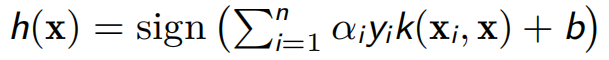

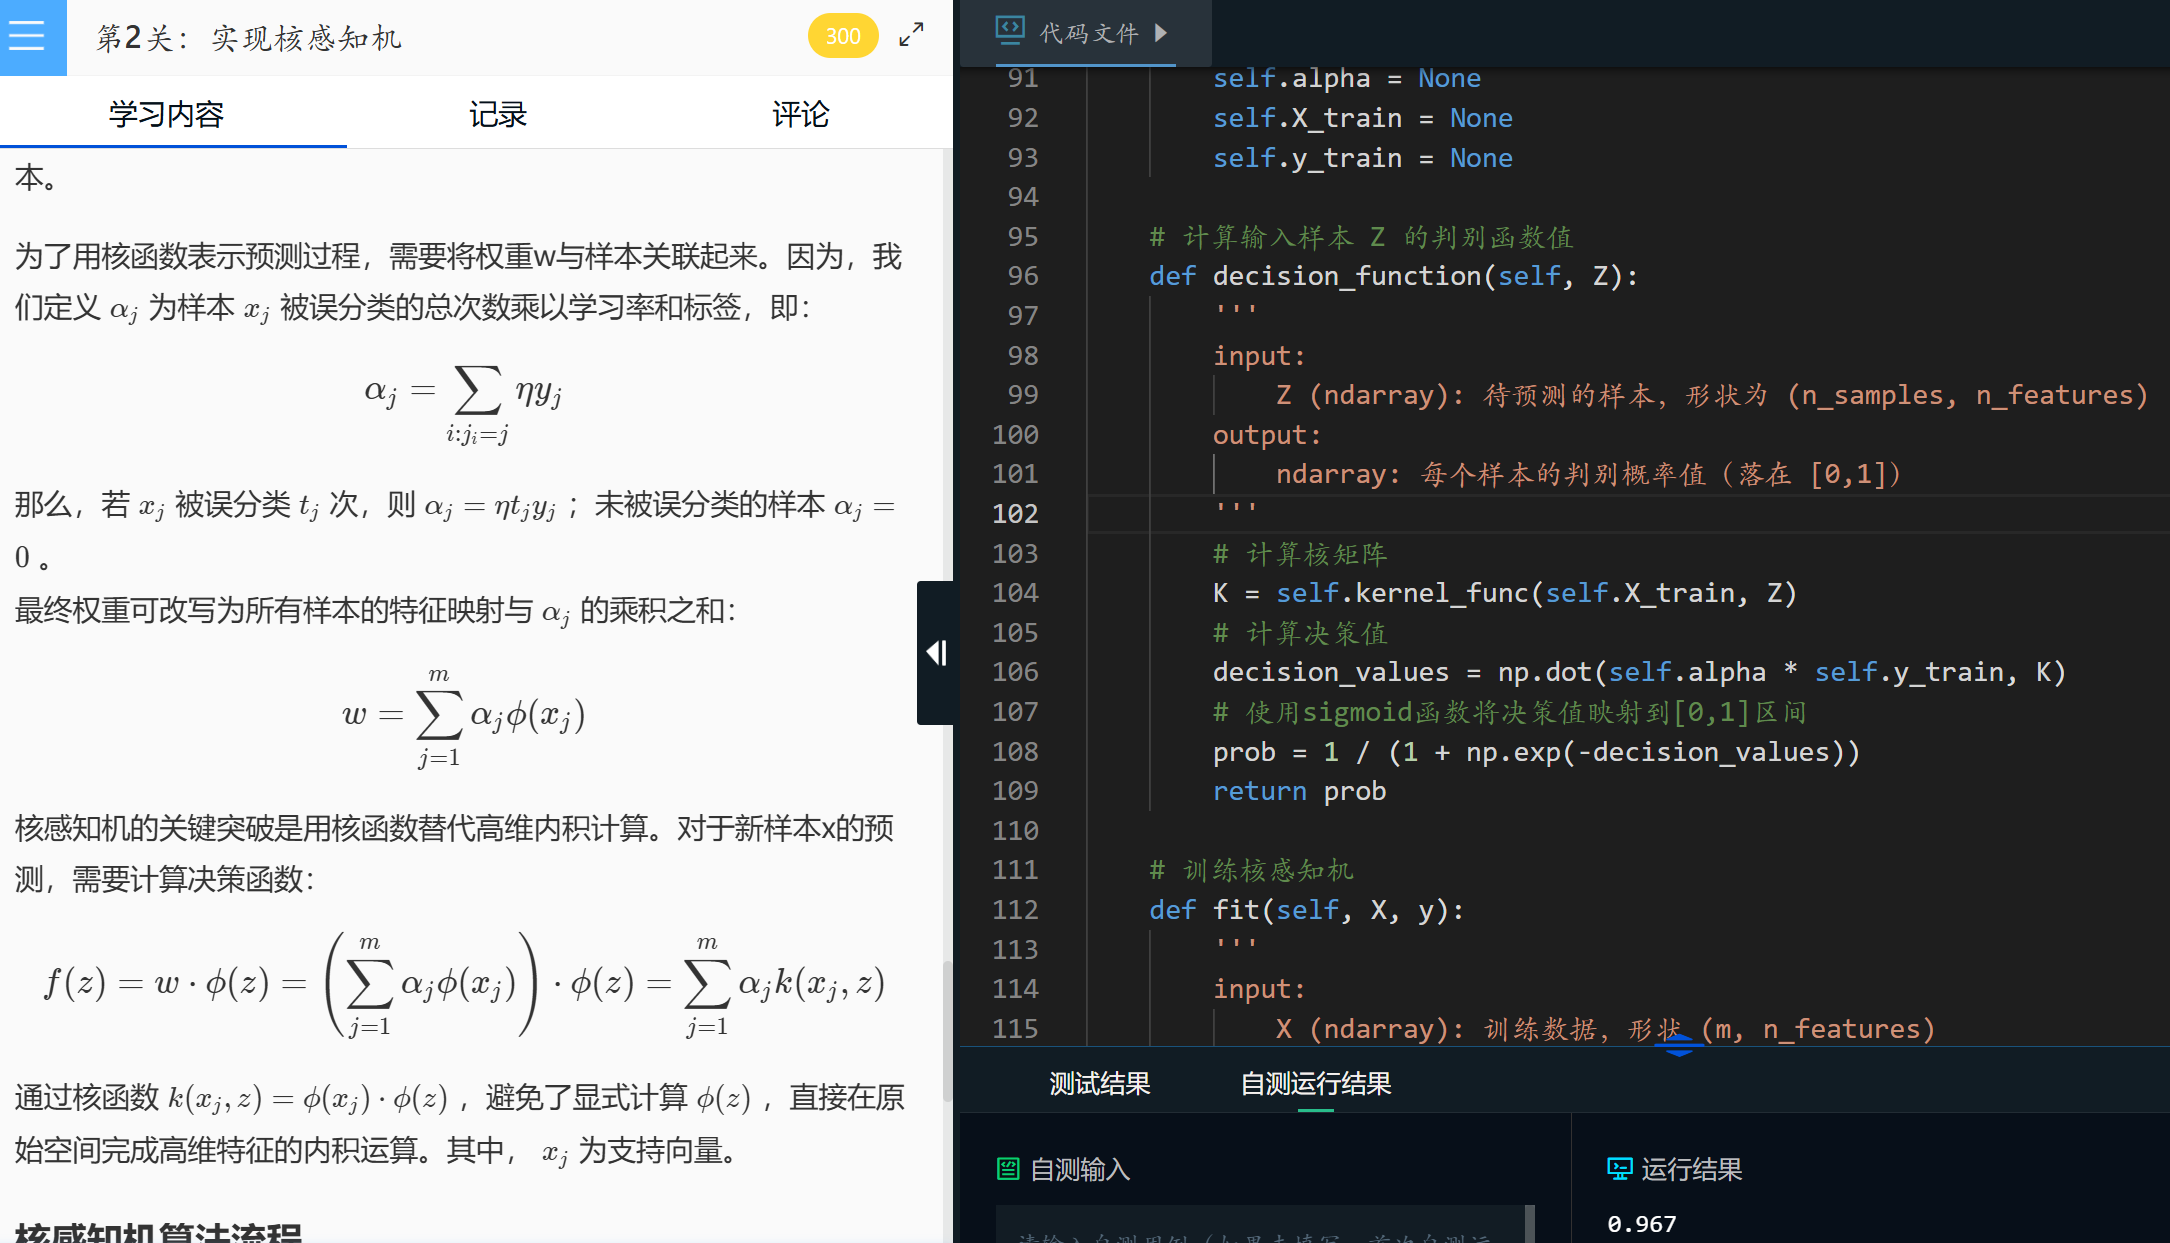
此alpha非彼alpha。代码中的alpha是左栏提示中的η（eta）*错误次数，所以每次错误要加eta_0。

### 一些小尝试

In [6]:
import numpy as np
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
np.sum(X**2, axis=1)

array([0, 1, 1, 2])

In [ ]:
X[1:, :, np.newaxis], X[1:, :, np.newaxis].shape

(array([[[0],
         [1]],
 
        [[1],
         [0]],
 
        [[1],
         [1]]]),
 (3, 2, 1))

In [9]:
X[:, np.newaxis, :], X[:, np.newaxis, :].shape

(array([[[0, 0]],
 
        [[0, 1]],
 
        [[1, 0]],
 
        [[1, 1]]]),
 (4, 1, 2))

In [17]:
X[:, np.newaxis, :] - X[np.newaxis, :, :], X[:, np.newaxis, :].shape, X[np.newaxis, :, :].shape, (X[:, np.newaxis, :] - X[np.newaxis, :, :]).shape

(array([[[ 0,  0],
         [ 0, -1],
         [-1,  0],
         [-1, -1]],
 
        [[ 0,  1],
         [ 0,  0],
         [-1,  1],
         [-1,  0]],
 
        [[ 1,  0],
         [ 1, -1],
         [ 0,  0],
         [ 0, -1]],
 
        [[ 1,  1],
         [ 1,  0],
         [ 0,  1],
         [ 0,  0]]]),
 (4, 1, 2),
 (1, 4, 2),
 (4, 4, 2))

## 第三关 实现核对数几率回归

>教学图片
![机器学习实践](.\\机器学习实践_4_3_1.png)
![核对数几率回归算法流程](.\\机器学习实践_4_3_2.png)

> 参考代码：

In [ ]:
# 参考代码（可通过，但读后我认为有些复杂和冗余部分，也有一些可能算作错误不合题意的地方，故做了修改，可以自行尝试修改、测试得到一个你认为合理的代码）
import numpy as np

# 这里需要将你在第一关中实现的核函数粘贴过来
class Kernel(object):
    def __init__(self, gamma=1.0, coef0=1, degree=3):
        '''
        初始化核函数参数
        input:
            gamma (float): 核函数的缩放参数
            coef0 (float): 多项式核中的常数项
            degree (int): 多项式核的次数
        '''
        self.gamma, self.coef0, self.degree = gamma, coef0, degree

    def linear(self, X1, X2):
        '''
        线性核函数
        input:
            X1 (ndarray): 形状 (n_samples1, n_features) 的样本矩阵
            X2 (ndarray): 形状 (n_samples2, n_features) 的样本矩阵
        output:
            ndarray: 线性核矩阵
        '''
        #********* Begin *********#
        return np.dot(X1, X2.T)
        #********* End *********#


    def poly(self, X1, X2):
        '''
        多项式核函数
        input:
            X1 (ndarray): 样本矩阵
            X2 (ndarray): 样本矩阵
        output:
            ndarray: 多项式核矩阵
        '''
        #********* Begin *********#
        return (self.gamma * np.dot(X1, X2.T) + self.coef0) ** self.degree
        #********* End *********#


    def gaussian(self, X1, X2):
        '''
        高斯核 
        input:
            X1 (ndarray): 样本矩阵
            X2 (ndarray): 样本矩阵
        output:
            ndarray: 高斯核矩阵
        '''
        #********* Begin *********#
        # 计算样本间的平方欧氏距离
        X1_norm = np.sum(X1**2, axis=1)
        X2_norm = np.sum(X2**2, axis=1)
        distances = X1_norm[:, np.newaxis] + X2_norm - 2 * np.dot(X1, X2.T)
        return np.exp(-self.gamma * distances)
        #********* End *********#


    def laplace(self, X1, X2):
        '''
        拉普拉斯核
        input:
            X1 (ndarray): 样本矩阵
            X2 (ndarray): 样本矩阵
        output:
            ndarray: 拉普拉斯核矩阵
        '''
        #********* Begin *********#
        # 计算样本间的L1距离（曼哈顿距离）
        distances = np.sum(np.abs(X1[:, np.newaxis, :] - X2), axis=2)
        return np.exp(-self.gamma * distances)
        #********* End *********#

class LogisticRegression(object):
    #********* Begin *********#
    def __init__(self, kernel_name='rbf', gamma=10, degree=2, coef0=1):
        '''
        input:
            kernel_name (str): 核函数类型 ('linear', 'poly', 'gaussian', 'laplace')
            gamma (float): 核函数的缩放系数
            degree (int): 多项式核的次数
            coef0 (float): 多项式核的常数项
        '''
        kernel_obj = Kernel(gamma=gamma, degree=degree, coef0=coef0)
        # 处理核函数名称别名
        if kernel_name == 'rbf':
            kernel_name = 'gaussian'
        self.kernel_func = getattr(kernel_obj, kernel_name)
        self.alpha = None  # 对偶参数
        self.X_train = None  # 训练数据
        self.bias = 0  # 偏置项
        self.X_mean = None  # 特征均值
        self.X_std = None   # 特征标准差
        self.kernel_name = kernel_name
        self.gamma = gamma
        self.C = 1.0  # 正则化参数
    
    # 特征标准化
    def _standardize(self, X, fit=False):
        if fit:
            self.X_mean = np.mean(X, axis=0)
            self.X_std = np.std(X, axis=0)
            # 避免除零错误
            self.X_std[self.X_std == 0] = 1.0
        
        return (X - self.X_mean) / self.X_std
    
    # Sigmoid 函数（逻辑回归输出概率）
    def _sigmoid(self, z):
        '''
        input:
            z (ndarray): 输入值
        output:
            ndarray: Sigmoid 变换后的概率值
        '''
        # 防止溢出
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    # 损失函数（负对数似然）
    def _cost(self, K, y, a, bias):
        '''
        input:
            K (ndarray): 核矩阵 (m, m)，K[i,j] = k(x_i, x_j)
            y (ndarray): 标签向量 (m,)，y ∈ {0,1}
            a (ndarray): 待优化的参数 (m,)
            bias (float): 偏置项
        output:
            float: 当前代价值
        '''
        m = len(y)
        # 计算预测概率
        z = np.dot(K, a) + bias
        h = self._sigmoid(z)
        
        # 计算正则化项（L2正则化）
        reg_term = 0.5 * self.C * np.dot(a, a) / m
        
        # 计算负对数似然损失
        cost = (-1/m) * np.sum(y * np.log(h + 1e-10) + (1 - y) * np.log(1 - h + 1e-10))
        
        return cost + reg_term

    # 损失函数对参数 a 的梯度
    def _gradient(self, K, y, a, bias):
        '''
        input:
            K (ndarray): 核矩阵
            y (ndarray): 标签向量
            a (ndarray): 参数
            bias (float): 偏置项
        output:
            tuple: (梯度向量, 偏置项梯度)
        '''
        m = len(y)
        # 计算预测概率
        z = np.dot(K, a) + bias
        h = self._sigmoid(z)
        
        # 计算正则化项的梯度
        reg_grad = self.C * a / m
        
        # 计算负对数似然的梯度
        grad_a = np.dot(K.T, (h - y)) / m + reg_grad
        grad_bias = np.sum(h - y) / m
        
        return grad_a, grad_bias
        
    # 训练
    def fit(self, X, y, max_rate=0.1, min_rate=0.001, gd_step=50, epsilon=1e-5):
        '''
        input:
            X (ndarray): 训练数据 (m, d)
            y (ndarray): 标签向量 (m,)
            max_rate (float): 学习率的最大值
            min_rate (float): 学习率的最小值
            gd_step (int): 学习率缩减因子
            epsilon (float): 损失函数收敛阈值
        '''
        # 标准化特征
        X_scaled = self._standardize(X, fit=True)
        
        m, n = X_scaled.shape
        self.X_train = X_scaled
        
        # 计算核矩阵
        K = self.kernel_func(X_scaled, X_scaled)
        
        # 初始化参数
        self.alpha = np.zeros(m)
        self.bias = 0
        
        # 初始化学习率
        learning_rate = max_rate
        prev_cost = float('inf')
        iteration = 0
        
        # 使用动量法加速收敛
        momentum = 0.9
        velocity_alpha = np.zeros_like(self.alpha)
        velocity_bias = 0
        
        # 梯度下降
        while True:
            # 计算当前损失和梯度
            cost = self._cost(K, y, self.alpha, self.bias)
            grad_alpha, grad_bias = self._gradient(K, y, self.alpha, self.bias)
            
            # 使用动量法更新参数
            velocity_alpha = momentum * velocity_alpha - learning_rate * grad_alpha
            velocity_bias = momentum * velocity_bias - learning_rate * grad_bias
            
            self.alpha += velocity_alpha
            self.bias += velocity_bias
            
            # 检查收敛条件
            if abs(prev_cost - cost) < epsilon:
                break
                
            prev_cost = cost
            iteration += 1
            
            # 学习率衰减
            if iteration % gd_step == 0:
                learning_rate = max(min_rate, learning_rate * 0.9)
            
            # 防止无限循环
            if iteration > 10000:
                break

    # 预测新样本的类别概率
    def predict(self, X):
        '''
        input:
            X (ndarray): 测试数据 (n, d)
        output:
            ndarray: 概率值（落在 [0,1]）
        '''
        # 标准化特征
        X_scaled = self._standardize(X)
        
        # 计算测试数据与训练数据的核矩阵
        K_test = self.kernel_func(self.X_train, X_scaled)
        
        # 计算预测值
        z = np.dot(K_test.T, self.alpha) + self.bias
        
        # 应用sigmoid函数得到概率
        return self._sigmoid(z)
    
    #********* End *********#

> 标准化有助于加快收敛速度。
> 正确代码(1)如下，测试96.7，有标准化，gamma=1.0即可；
> 正确代码(2)如下，测试96.7，但没有标准化，gamma=0.2即可；感觉与epsilon定在1e-5还是1e-6关系不大，主要是标准化的影响和gamma的影响。

| 代码版本 | 标准化 | gamma | 测试准确率 | 轮次 |
| -------- | ------ | ----- | ---------- | ---- |
| 正确代码(1) | 有     | 1.0   | 96.7       | 约285 |
| 正确代码(2) | 无     | 0.2   | 96.7       | 约258 |
| 正确代码(2) | 无     | 0.5   | 95.7       | 约191 |
| 正确代码(2) | 无     | 0.4   | 96.0       | 约204 |
| 正确代码(2) | 无     | 0.3   | 96.0       | 约29 |

In [ ]:
# 正确代码(1)
import numpy as np

# 这里需要将你在第一关中实现的核函数粘贴过来
class Kernel(object):
    def __init__(self, gamma=1.0, coef0=1, degree=3):
        '''
        初始化核函数参数
        input:
            gamma (float): 核函数的缩放参数
            coef0 (float): 多项式核中的常数项
            degree (int): 多项式核的次数
        '''
        self.gamma, self.coef0, self.degree = gamma, coef0, degree

    def linear(self, X1, X2):
        '''
        线性核函数
        input:
            X1 (ndarray): 形状 (n_samples1, n_features) 的样本矩阵
            X2 (ndarray): 形状 (n_samples2, n_features) 的样本矩阵
        output:
            ndarray: 线性核矩阵
        '''
        #********* Begin *********#
        return np.dot(X1, X2.T)
        #********* End *********#


    def poly(self, X1, X2):
        '''
        多项式核函数
        input:
            X1 (ndarray): 样本矩阵
            X2 (ndarray): 样本矩阵
        output:
            ndarray: 多项式核矩阵
        '''
        #********* Begin *********#
        return (np.dot(X1, X2.T) + self.coef0) ** self.degree
        #********* End *********#


    def gaussian(self, X1, X2):
        '''
        高斯核 
        input:
            X1 (ndarray): 样本矩阵
            X2 (ndarray): 样本矩阵
        output:
            ndarray: 高斯核矩阵
        '''
        #********* Begin *********#
        return np.exp(-(np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T))/(2*self.gamma**2))
        #********* End *********#


    def laplace(self, X1, X2):
        '''
        拉普拉斯核
        input:
            X1 (ndarray): 样本矩阵
            X2 (ndarray): 样本矩阵
        output:
            ndarray: 拉普拉斯核矩阵
        '''
        #********* Begin *********#
        return np.exp(-np.sum(np.abs(X1[:, np.newaxis, :] - X2[np.newaxis, :, :]), axis=2)/self.gamma)
        #********* End *********#

"""核对数几率回归算法流程：
1.初始化参数向量α为全0，构造核矩阵K
2.迭代训练（最多max_iter次）:
    - 计算当前损失函数；
    - 判断收敛条件：若相邻两次代价函数差小于阈值，提前结束；
    - 计算梯度g
    - 线搜索确定学习率η:
        + 从 max_rate 开始，逐步缩小（每次除以 gd_step）;
        + 在候选步长中选择使损失函数下降最多的η^∗
    - 参数更新：α←α+η^∗ * g"""
class LogisticRegression(object):
    #********* Begin *********#
    def __init__(self, kernel_name='gaussian', gamma=1.0, degree=3, coef0=1):
        '''
        input:
            kernel_name (str): 核函数类型 ('linear', 'poly', 'gaussian', 'laplace')
            gamma (float): 核函数的缩放系数
            degree (int): 多项式核的次数
            coef0 (float): 多项式核的常数项
        '''
        kernel_obj = Kernel(gamma=gamma, degree=degree, coef0=coef0)
        self.kernel_func = getattr(kernel_obj, kernel_name)
        self.alpha = None  # 对偶参数
        self.X_train = None  # 训练数据
        self.bias = 0  # 偏置项
        self.X_mean = None  # 特征均值
        self.X_std = None   # 特征标准差
        self.kernel_name = kernel_name
        self.gamma = gamma
        self.C = 1.0  # 正则化参数
    # 特征标准化
    def _standardize(self, X, fit=False):
        if fit:
            self.X_mean = np.mean(X, axis=0)
            self.X_std = np.std(X, axis=0)
            # 避免除零错误
            self.X_std[self.X_std == 0] = 1.0
        
        return (X - self.X_mean) / self.X_std

    # Sigmoid 函数（逻辑回归输出概率）
    def _sigmoid(self, z):
        '''
        input:
            z (ndarray): 输入值
        output:
            ndarray: Sigmoid 变换后的概率值
        '''
        # 防止溢出
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    
    # 损失函数（负对数似然）
    def _cost(self, K, y, a):
        '''
        input:
            K (ndarray): 核矩阵 (m, m)，K[i,j] = k(x_i, x_j)
            y (ndarray): 标签向量 (m,)，y ∈ {0,1}
            a (ndarray): 待优化的参数 (m,)
        output:
            float: 当前代价值
        '''
        m = len(y)
        # 计算预测概率
        z = np.dot(K, a) + self.bias
        h = self._sigmoid(z)
        
        # 计算正则化项（L2正则化）
        reg_term = 0.5 * self.C * np.dot(a, a) / m # 正则化项，防止过拟合，删去后正确率由0.96降至0.95
        
        # 计算负对数似然损失
        cost = (-1/m) * np.sum(y * np.log(h + 1e-10) + (1 - y) * np.log(1 - h + 1e-10)) # 此处的(1-y)前面的应该是负号
        
        return cost + reg_term
       

    # 损失函数对参数 a 的梯度
    def _gradient(self, K, y, a):
        '''
        input:
            K (ndarray): 核矩阵
            y (ndarray): 标签向量
            a (ndarray): 参数
        output:
            ndarray: 梯度向量
        '''
        m = len(y)
        # 计算预测概率
        z = np.dot(K, a) + self.bias
        h = self._sigmoid(z)
        
        # 计算正则化项的梯度
        reg_grad = self.C * a / m
        
        # 计算负对数似然的梯度
        grad_a = np.dot(K.T, (h - y)) / m + reg_grad
        self.bias = np.sum(h - y) / m
        
        return grad_a
        
    # 训练
    def fit(self, X, y, max_rate=0.1, min_rate=0.001, gd_step=50, epsilon=1e-5):
        '''
        input:
            X (ndarray): 训练数据 (m, d)
            y (ndarray): 标签向量 (m,)
            max_rate (float): 学习率的最大值
            min_rate (float): 学习率的最小值
            gd_step (int): 学习率缩减因子
            epsilon (float): 损失函数收敛阈值
        '''
        # 标准化特征
        X_scaled = self._standardize(X, fit=True)
        
        m, n = X_scaled.shape
        self.X_train = X_scaled
        
        # 计算核矩阵
        K = self.kernel_func(X_scaled, X_scaled)
        
        # 初始化参数
        self.alpha = np.zeros(m)
        self.bias = 0
        
        # 初始化学习率
        learning_rate = max_rate
        prev_cost = float('inf')
        iteration = 0
        
        # 使用动量法加速收敛
        momentum = 0.9
        velocity_alpha = np.zeros_like(self.alpha)
        velocity_bias = 0
        
        # 梯度下降
        while True:
            # 计算当前损失和梯度
            cost = self._cost(K, y, self.alpha)
            grad_alpha = self._gradient(K, y, self.alpha)
            
            # 使用动量法更新参数
            velocity_alpha = momentum * velocity_alpha - learning_rate * grad_alpha
            velocity_bias = momentum * velocity_bias - learning_rate * self.bias
            
            self.alpha += velocity_alpha
            self.bias += velocity_bias
            
            # 检查收敛条件
            if abs(prev_cost - cost) < epsilon:
                print(f'Converged after {iteration} iterations.')
                break
                
            prev_cost = cost
            iteration += 1
            
            # 学习率衰减
            if iteration % gd_step == 0:
                learning_rate = max(min_rate, learning_rate * 0.9)
            
            # 防止无限循环
            if iteration > 10000:
                print('Reached maximum iterations {iteration}.')
                break



    # 预测新样本的类别概率
    def predict(self, X):
        '''
        input:
            X (ndarray): 测试数据 (n, d)
        output:
            ndarray: 概率值（落在 [0,1]）
        '''
        # 标准化特征
        X_scaled = self._standardize(X)
        
        # 计算测试数据与训练数据的核矩阵
        K_test = self.kernel_func(self.X_train, X_scaled)
        
        # 计算预测值
        z = np.dot(K_test.T, self.alpha) + self.bias
        
        # 应用sigmoid函数得到概率
        return self._sigmoid(z)  
    
    #********* End *********#

In [ ]:
# 正确代码(2)
import numpy as np

# 这里需要将你在第一关中实现的核函数粘贴过来
class Kernel(object):
    def __init__(self, gamma=1.0, coef0=1, degree=3):
        '''
        初始化核函数参数
        input:
            gamma (float): 核函数的缩放参数
            coef0 (float): 多项式核中的常数项
            degree (int): 多项式核的次数
        '''
        self.gamma, self.coef0, self.degree = gamma, coef0, degree

    def linear(self, X1, X2):
        '''
        线性核函数
        input:
            X1 (ndarray): 形状 (n_samples1, n_features) 的样本矩阵
            X2 (ndarray): 形状 (n_samples2, n_features) 的样本矩阵
        output:
            ndarray: 线性核矩阵
        '''
        #********* Begin *********#
        return np.dot(X1, X2.T)
        #********* End *********#


    def poly(self, X1, X2):
        '''
        多项式核函数
        input:
            X1 (ndarray): 样本矩阵
            X2 (ndarray): 样本矩阵
        output:
            ndarray: 多项式核矩阵
        '''
        #********* Begin *********#
        return (np.dot(X1, X2.T) + self.coef0) ** self.degree
        #********* End *********#


    def gaussian(self, X1, X2):
        '''
        高斯核 
        input:
            X1 (ndarray): 样本矩阵
            X2 (ndarray): 样本矩阵
        output:
            ndarray: 高斯核矩阵
        '''
        #********* Begin *********#
        return np.exp(-(np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T))/(2*self.gamma**2))
        #********* End *********#


    def laplace(self, X1, X2):
        '''
        拉普拉斯核
        input:
            X1 (ndarray): 样本矩阵
            X2 (ndarray): 样本矩阵
        output:
            ndarray: 拉普拉斯核矩阵
        '''
        #********* Begin *********#
        return np.exp(-np.sum(np.abs(X1[:, np.newaxis, :] - X2[np.newaxis, :, :]), axis=2)/self.gamma)
        #********* End *********#

"""核对数几率回归算法流程：
1.初始化参数向量α为全0，构造核矩阵K
2.迭代训练（最多max_iter次）:
    - 计算当前损失函数；
    - 判断收敛条件：若相邻两次代价函数差小于阈值，提前结束；
    - 计算梯度g
    - 线搜索确定学习率η:
        + 从 max_rate 开始，逐步缩小（每次除以 gd_step）;
        + 在候选步长中选择使损失函数下降最多的η^∗
    - 参数更新：α←α+η^∗ * g"""
class LogisticRegression(object):
    #********* Begin *********#
    def __init__(self, kernel_name='gaussian', gamma=0.5, degree=3, coef0=1):
        '''
        input:
            kernel_name (str): 核函数类型 ('linear', 'poly', 'gaussian', 'laplace')
            gamma (float): 核函数的缩放系数
            degree (int): 多项式核的次数
            coef0 (float): 多项式核的常数项
        '''
        kernel_obj = Kernel(gamma=gamma, degree=degree, coef0=coef0)
        self.kernel_func = getattr(kernel_obj, kernel_name)
        self.alpha = None  # 对偶参数
        self.X_train = None  # 训练数据
        self.bias = 0  # 偏置项
        self.X_mean = None  # 特征均值
        self.X_std = None   # 特征标准差
        self.kernel_name = kernel_name
        self.gamma = gamma
        self.C = 1.0  # 正则化参数

    # Sigmoid 函数（逻辑回归输出概率）
    def _sigmoid(self, z):
        '''
        input:
            z (ndarray): 输入值
        output:
            ndarray: Sigmoid 变换后的概率值
        '''
        # 防止溢出
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    
    # 损失函数（负对数似然）
    def _cost(self, K, y, a):
        '''
        input:
            K (ndarray): 核矩阵 (m, m)，K[i,j] = k(x_i, x_j)
            y (ndarray): 标签向量 (m,)，y ∈ {0,1}
            a (ndarray): 待优化的参数 (m,)
        output:
            float: 当前代价值
        '''
        m = len(y)
        # 计算预测概率
        z = np.dot(K, a) + self.bias
        h = self._sigmoid(z)
        
        # 计算正则化项（L2正则化）
        reg_term = 0.5 * self.C * np.dot(a, a) / m
        
        # 计算负对数似然损失
        cost = (-1/m) * np.sum(y * np.log(h + 1e-10) + (1 - y) * np.log(1 - h + 1e-10))
        
        return cost + reg_term
       

    # 损失函数对参数 a 的梯度
    def _gradient(self, K, y, a):
        '''
        input:
            K (ndarray): 核矩阵
            y (ndarray): 标签向量
            a (ndarray): 参数
        output:
            ndarray: 梯度向量
        '''
        m = len(y)
        # 计算预测概率
        z = np.dot(K, a) + self.bias
        h = self._sigmoid(z)
        
        # 计算正则化项的梯度
        reg_grad = self.C * a / m
        
        # 计算负对数似然的梯度
        grad_a = np.dot(K.T, (h - y)) / m + reg_grad
        self.bias = np.sum(h - y) / m
        
        return grad_a
        
    # 训练
    def fit(self, X, y, max_rate=0.1, min_rate=0.001, gd_step=50, epsilon=1e-5):
        '''
        input:
            X (ndarray): 训练数据 (m, d)
            y (ndarray): 标签向量 (m,)
            max_rate (float): 学习率的最大值
            min_rate (float): 学习率的最小值
            gd_step (int): 学习率缩减因子
            epsilon (float): 损失函数收敛阈值
        '''
        # 标准化特征
        X_scaled = X
        
        m, n = X_scaled.shape
        self.X_train = X_scaled
        
        # 计算核矩阵
        K = self.kernel_func(X_scaled, X_scaled)
        
        # 初始化参数
        self.alpha = np.zeros(m)
        self.bias = 0
        
        # 初始化学习率
        learning_rate = max_rate
        prev_cost = float('inf')
        iteration = 0
        
        # 使用动量法加速收敛
        momentum = 0.9
        velocity_alpha = np.zeros_like(self.alpha)
        velocity_bias = 0
        
        # 梯度下降
        while True:
            # 计算当前损失和梯度
            cost = self._cost(K, y, self.alpha)
            grad_alpha = self._gradient(K, y, self.alpha)
            
            # 使用动量法更新参数
            velocity_alpha = momentum * velocity_alpha - learning_rate * grad_alpha
            velocity_bias = momentum * velocity_bias - learning_rate * self.bias
            
            self.alpha += velocity_alpha
            self.bias += velocity_bias
            
            # 检查收敛条件
            if abs(prev_cost - cost) < epsilon:
                print(f'Converged after {iteration} iterations.')
                break
                
            prev_cost = cost
            iteration += 1
            
            # 学习率衰减
            if iteration % gd_step == 0:
                learning_rate = max(min_rate, learning_rate * 0.9)
            
            # 防止无限循环
            if iteration > 10000:
                print('Reached maximum iterations {iteration}.')
                break



    # 预测新样本的类别概率
    def predict(self, X):
        '''
        input:
            X (ndarray): 测试数据 (n, d)
        output:
            ndarray: 概率值（落在 [0,1]）
        '''
        # 标准化特征
        X_scaled = X
        
        # 计算测试数据与训练数据的核矩阵
        K_test = self.kernel_func(self.X_train, X_scaled)
        
        # 计算预测值
        z = np.dot(K_test.T, self.alpha) + self.bias
        
        # 应用sigmoid函数得到概率
        return self._sigmoid(z)  
    
    #********* End *********#

In [ ]:
# 正确代码(3)
import numpy as np

# 这里需要将你在第一关中实现的核函数粘贴过来
class Kernel(object):
    def __init__(self, gamma=1.0, coef0=1, degree=3):
        '''
        初始化核函数参数
        input:
            gamma (float): 核函数的缩放参数
            coef0 (float): 多项式核中的常数项
            degree (int): 多项式核的次数
        '''
        self.gamma, self.coef0, self.degree = gamma, coef0, degree

    def linear(self, X1, X2):
        '''
        线性核函数
        input:
            X1 (ndarray): 形状 (n_samples1, n_features) 的样本矩阵
            X2 (ndarray): 形状 (n_samples2, n_features) 的样本矩阵
        output:
            ndarray: 线性核矩阵
        '''
        #********* Begin *********#
        return np.dot(X1, X2.T)
        #********* End *********#


    def poly(self, X1, X2):
        '''
        多项式核函数
        input:
            X1 (ndarray): 样本矩阵
            X2 (ndarray): 样本矩阵
        output:
            ndarray: 多项式核矩阵
        '''
        #********* Begin *********#
        return (np.dot(X1, X2.T) + self.coef0) ** self.degree
        #********* End *********#


    def gaussian(self, X1, X2):
        '''
        高斯核 
        input:
            X1 (ndarray): 样本矩阵
            X2 (ndarray): 样本矩阵
        output:
            ndarray: 高斯核矩阵
        '''
        #********* Begin *********#
        return np.exp(-(np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T))/(2*self.gamma**2))
        #********* End *********#


    def laplace(self, X1, X2):
        '''
        拉普拉斯核
        input:
            X1 (ndarray): 样本矩阵
            X2 (ndarray): 样本矩阵
        output:
            ndarray: 拉普拉斯核矩阵
        '''
        #********* Begin *********#
        return np.exp(-np.sum(np.abs(X1[:, np.newaxis, :] - X2[np.newaxis, :, :]), axis=2)/self.gamma)
        #********* End *********#

"""核对数几率回归算法流程：
1.初始化参数向量α为全0，构造核矩阵K
2.迭代训练（最多max_iter次）:
    - 计算当前损失函数；
    - 判断收敛条件：若相邻两次代价函数差小于阈值，提前结束；
    - 计算梯度g
    - 线搜索确定学习率η:
        + 从 max_rate 开始，逐步缩小（每次除以 gd_step）;
        + 在候选步长中选择使损失函数下降最多的η^∗
    - 参数更新：α←α+η^∗ * g"""
class LogisticRegression(object):
    #********* Begin *********#
    def __init__(self, kernel_name='gaussian', gamma=0.3, degree=3, coef0=1):
        '''
        input:
            kernel_name (str): 核函数类型 ('linear', 'poly', 'gaussian', 'laplace')
            gamma (float): 核函数的缩放系数
            degree (int): 多项式核的次数
            coef0 (float): 多项式核的常数项
        '''
        kernel_obj = Kernel(gamma=gamma, degree=degree, coef0=coef0)
        self.kernel_func = getattr(kernel_obj, kernel_name)
        self.alpha = None
        self.gamma = gamma

    # Sigmoid 函数（逻辑回归输出概率）
    def _sigmoid(self, z):
        '''
        input:
            z (ndarray): 输入值
        output:
            ndarray: Sigmoid 变换后的概率值
        '''
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    
    # 损失函数（负对数似然）
    def _cost(self, K, y, a):
        '''
        input:
            K (ndarray): 核矩阵 (m, m)，K[i,j] = k(x_i, x_j)
            y (ndarray): 标签向量 (m,)，y ∈ {0,1}
            a (ndarray): 待优化的参数 (m,)
        output:
            float: 当前代价值
        '''
        m = len(y)
        assert(m!=0)
        p = self._sigmoid(np.dot(K, a))
        cost = (-1) * np.sum(y * np.log(p + 1e-9) - (1 - y) * np.log(1 - p + 1e-9))
        
        return cost

    # 损失函数对参数 a 的梯度
    def _gradient(self, K, y, a):
        '''
        input:
            K (ndarray): 核矩阵
            y (ndarray): 标签向量
            a (ndarray): 参数
        output:
            ndarray: 梯度向量
        '''
        m = len(y)
        assert(m!=0)
        p = self._sigmoid(np.dot(K, a))
        grad_a = np.dot(K.T, (p - y))
        return grad_a
        
    # 训练
    def fit(self, X, y, max_rate=0.1, min_rate=0.001, gd_step=50, epsilon=1e-5):
        '''
        input:
            X (ndarray): 训练数据 (m, d)
            y (ndarray): 标签向量 (m,)
            max_rate (float): 学习率的最大值
            min_rate (float): 学习率的最小值
            gd_step (int): 学习率缩减因子
            epsilon (float): 损失函数收敛阈值
        '''
        m = X.shape[0]
        self.X_train = X
        K = self.kernel_func(X, X)
        
        # 初始化
        self.alpha = np.zeros(m)
        learning_rate = max_rate
        prev_cost = float('inf')
        iteration = 0
        
        # 梯度下降
        for iteration in range(1001):
            # 计算当前损失和梯度
            cost = self._cost(K, y, self.alpha)
            grad_alpha = self._gradient(K, y, self.alpha)
            # 更新alpha
            self.alpha -= learning_rate * grad_alpha
            
            # 检查收敛与否
            if abs(prev_cost - cost) < epsilon:
                # print(f'Converged after {iteration} iterations.')
                break 
            prev_cost = cost

    # 预测新样本的类别概率
    def predict(self, X):
        '''
        input:
            X (ndarray): 测试数据 (n, d)
        output:
            ndarray: 概率值（落在 [0,1]）
        '''
        K = self.kernel_func(self.X_train, X)
        return self._sigmoid(np.dot(K.T, self.alpha))  

In [ ]:
# 正确代码(4)：加入了对最优学习率的线搜索
import numpy as np

# 这里需要将你在第一关中实现的核函数粘贴过来
class Kernel(object):
    def __init__(self, gamma=1.0, coef0=1, degree=3):
        '''
        初始化核函数参数
        input:
            gamma (float): 核函数的缩放参数
            coef0 (float): 多项式核中的常数项
            degree (int): 多项式核的次数
        '''
        self.gamma, self.coef0, self.degree = gamma, coef0, degree

    def linear(self, X1, X2):
        '''
        线性核函数
        input:
            X1 (ndarray): 形状 (n_samples1, n_features) 的样本矩阵
            X2 (ndarray): 形状 (n_samples2, n_features) 的样本矩阵
        output:
            ndarray: 线性核矩阵
        '''
        #********* Begin *********#
        return np.dot(X1, X2.T)
        #********* End *********#


    def poly(self, X1, X2):
        '''
        多项式核函数
        input:
            X1 (ndarray): 样本矩阵
            X2 (ndarray): 样本矩阵
        output:
            ndarray: 多项式核矩阵
        '''
        #********* Begin *********#
        return (np.dot(X1, X2.T) + self.coef0) ** self.degree
        #********* End *********#


    def gaussian(self, X1, X2):
        '''
        高斯核 
        input:
            X1 (ndarray): 样本矩阵
            X2 (ndarray): 样本矩阵
        output:
            ndarray: 高斯核矩阵
        '''
        #********* Begin *********#
        return np.exp(-(np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T))/(2*self.gamma**2))
        #********* End *********#


    def laplace(self, X1, X2):
        '''
        拉普拉斯核
        input:
            X1 (ndarray): 样本矩阵
            X2 (ndarray): 样本矩阵
        output:
            ndarray: 拉普拉斯核矩阵
        '''
        #********* Begin *********#
        return np.exp(-np.sum(np.abs(X1[:, np.newaxis, :] - X2[np.newaxis, :, :]), axis=2)/self.gamma)
        #********* End *********#

"""核对数几率回归算法流程：
1.初始化参数向量α为全0，构造核矩阵K
2.迭代训练（最多max_iter次）:
    - 计算当前损失函数；
    - 判断收敛条件：若相邻两次代价函数差小于阈值，提前结束；
    - 计算梯度g
    - 线搜索确定学习率η:
        + 从 max_rate 开始，逐步缩小（每次除以 gd_step）;
        + 在候选步长中选择使损失函数下降最多的η^∗
    - 参数更新：α←α+η^∗ * g"""
class LogisticRegression(object):
    #********* Begin *********#
    def __init__(self, kernel_name='gaussian', gamma=0.3, degree=3, coef0=1):
        '''
        input:
            kernel_name (str): 核函数类型 ('linear', 'poly', 'gaussian', 'laplace')
            gamma (float): 核函数的缩放系数
            degree (int): 多项式核的次数
            coef0 (float): 多项式核的常数项
        '''
        kernel_obj = Kernel(gamma=gamma, degree=degree, coef0=coef0)
        self.kernel_func = getattr(kernel_obj, kernel_name)
        self.alpha = None
        self.gamma = gamma

    # Sigmoid 函数（逻辑回归输出概率）
    def _sigmoid(self, z):
        '''
        input:
            z (ndarray): 输入值
        output:
            ndarray: Sigmoid 变换后的概率值
        '''
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    
    # 损失函数（负对数似然）
    def _cost(self, K, y, a):
        '''
        input:
            K (ndarray): 核矩阵 (m, m)，K[i,j] = k(x_i, x_j)
            y (ndarray): 标签向量 (m,)，y ∈ {0,1}
            a (ndarray): 待优化的参数 (m,)
        output:
            float: 当前代价值
        '''
        m = len(y)
        assert(m!=0)
        p = self._sigmoid(np.dot(K, a))
        cost = (-1) * np.sum(y * np.log(p + 1e-9) - (1 - y) * np.log(1 - p + 1e-9))
        
        return cost

    # 损失函数对参数 a 的梯度
    def _gradient(self, K, y, a):
        '''
        input:
            K (ndarray): 核矩阵
            y (ndarray): 标签向量
            a (ndarray): 参数
        output:
            ndarray: 梯度向量
        '''
        m = len(y)
        assert(m!=0)
        p = self._sigmoid(np.dot(K, a))
        grad_a = np.dot(K.T, (p - y))
        return grad_a
        
    # 训练
    def fit(self, X, y, max_rate=0.3, min_rate=0.001, gd_step=1.1, epsilon=1e-5):
        '''
        input:
            X (ndarray): 训练数据 (m, d)
            y (ndarray): 标签向量 (m,)
            max_rate (float): 学习率的最大值
            min_rate (float): 学习率的最小值
            gd_step (int): 学习率缩减因子
            epsilon (float): 损失函数收敛阈值
        '''
        m = X.shape[0]
        self.X_train = X
        K = self.kernel_func(X, X)
        
        # 初始化
        self.alpha = np.zeros(m)
        learning_rate = max_rate
        prev_cost = float('inf')
        iteration = 0
        
        # 梯度下降
        for iteration in range(1001):
            # 计算当前损失和梯度
            cost = self._cost(K, y, self.alpha)
            # 检查收敛与否
            if abs(prev_cost - cost) < epsilon:
                print(f'Converged after {iteration} iterations.')
                break             
            # 计算梯度
            grad_alpha = self._gradient(K, y, self.alpha)
            """- 线搜索确定学习率η:
            + 从 max_rate 开始，逐步缩小（每次除以 gd_step）;
            + 在候选步长中选择使损失函数下降最多的η^∗"""
            # 线搜索确定学习率η
            best_cost = float('inf')
            best_rate = learning_rate
            for step in range(10):
                candidate_rate = max_rate / (gd_step ** step)
                candidate_alpha = self.alpha - candidate_rate * grad_alpha
                candidate_cost = self._cost(K, y, candidate_alpha)
                if candidate_cost < best_cost:
                    best_cost = candidate_cost
                    best_rate = candidate_rate
            learning_rate = best_rate
            print(learning_rate)
            # 更新alpha
            self.alpha -= learning_rate * grad_alpha
            

            prev_cost = cost

    # 预测新样本的类别概率
    def predict(self, X):
        '''
        input:
            X (ndarray): 测试数据 (n, d)
        output:
            ndarray: 概率值（落在 [0,1]）
        '''
        K = self.kernel_func(self.X_train, X)
        return self._sigmoid(np.dot(K.T, self.alpha))  